#  MelodyMaster
## Notebook04 - Dataset & Morphology
### Idan Kashani & Or Raphael Bidusa

# If you want something done right, do it yourself
With our current dataset we face three main problems:
* The dataset is noisy and some labels got mixed up.
* The label that we are trying to predict is the artist and not the lyricist - which might be harder to learn.
* The text has already undergone an initial process of processing and not the type we want.
Therefore, we have decided to build the dataset ourselves.

In [2]:
import ast
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
from datetime import datetime
warnings.filterwarnings("ignore")
np.random.seed(42)

### Loading the original dataset

In [3]:
df = pd.read_csv('./dataset.csv')
print(f"Dataset's shape: {df.shape}")
print(df.columns)

Dataset's shape: (14543, 8)
Index(['index', 'artist', 'lyrics', 'song_name', 'artist_key', 'url',
       'words count', 'unique words count'],
      dtype='object')


We'll define two functions that will help us with the initial cleaning of the lyrics - one for removing the Niqqud and one for inserting the special token `<s>` at the beginning of a sentence and <\s> at the end.

In [4]:
def clean_niqqud(lyrics):
    return ''.join(['' if 1456 <= ord(c) <= 1479 else c for c in lyrics])

def line_format(list_of_strings):
    return '<s> ' + '<s> '.join('{} <\\s> '.format(line) for line in list_of_strings)

The following is using web scraping for [shironet](https://shironet.mako.co.il/) is order to extract the new database.
It takes about 5 hours to run, but we made it save a copy every 25 entries, so you can stop it anytime you want and continue from the last checkpoint.
We ran this code using `script04.py` file and not this code cell, you are more than welcome to do so yourself, but an already scarped data is already present in the current dir.

In [ ]:
f = open("./lyricist.txt", "r", encoding='utf-8')
lyricist_list = ast.literal_eval(f.read())
f.close()
f = open("./lyrics.txt", "r", encoding='utf-8')
lyrics_list = ast.literal_eval(f.read())
f.close()
f = open("./artists.txt", "r", encoding='utf-8')
artists_list = ast.literal_eval(f.read())
f.close()

print(f"Starting at {len(lyrics_list)}")
for index in range(len(df)):
    if index < len(lyricist_list):
        continue
    if index % 25 == 0:
        print(index)
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Current Time =", current_time)
        f = open("./lyricist.txt", "w", encoding='utf-8')
        f.write(str(lyricist_list))
        f.close()
        f = open("./lyrics.txt", "w", encoding='utf-8')
        f.write(str(lyrics_list))
        f.close()
        f = open("./artists.txt", "w", encoding='utf-8')
        f.write(str(artists_list))
        f.close()
        print(len(lyricist_list), len(lyrics_list), len(artists_list))
        if len(lyricist_list) != len(lyrics_list) or len(lyricist_list) != len(artists_list) or len(
                lyricist_list) != index:
            print("OY VEYYYYYYYYYYYYYYYYYYYYYYYY")

    song_url = ""
    try:
        song_url = df.loc[index, 'url']
        identifier = df.loc[index, 'index']
        reqs = requests.get(song_url)
    except:
        print(song_url)
        lyricist_list[identifier] = None
        lyrics_list[identifier] = None
        artists_list[identifier] = None
        continue
    soup = BeautifulSoup(reqs.text, 'html.parser')
    get_lyricist = soup.find("meta", itemprop="lyricist")
    get_lyrics = soup.find("span", {'class': 'artist_lyrics_text'})
    get_artists = soup.find("a", {"class": "artist_singer_title"})
    if not get_lyricist or not get_lyrics:
        print(song_url)
        lyricist_list[identifier] = None
        lyrics_list[identifier] = None
        artists_list[identifier] = None
        continue
    lyricists = get_lyricist["content"].split(',')
    lyricists = list(map(str.strip, lyricists))
    lyricist_list[identifier] = lyricists
    if not get_artists:
        artists_list[identifier] = lyricists
    else:
        artist = get_artists.getText().strip()
        artists_list[identifier] = artist
    lyrics = line_format(list(map(str.rstrip, get_lyrics.strings)))
    lyrics = clean_niqqud(lyrics)
    lyrics_list[identifier] = lyrics


f = open("./lyricist.txt", "w", encoding='utf-8')
f.write(str(lyricist_list))
f.close()
f = open("./lyrics.txt", "w", encoding='utf-8')
f.write(str(lyrics_list))
f.close()
f = open("./artists.txt", "w", encoding='utf-8')
f.write(str(artists_list))
f.close()

We will load the already scraped data and assemble our new, fresh dataset.

In [5]:
f = open("./lyricist.txt", "r", encoding='utf-8')
lyricist_list = ast.literal_eval(f.read())
f.close()
f = open("./lyrics.txt", "r", encoding='utf-8')
lyrics_list = ast.literal_eval(f.read())
f.close()
f = open("./artists.txt", "r", encoding='utf-8')
artists_list = ast.literal_eval(f.read())
f.close()
print(f"The size of the lyricist list: {len(lyricist_list)}")
print(f"The size of the lyrics list: {len(lyrics_list)}")
print(f"The size of the artists list: {len(artists_list)}")

for i in range(len(artists_list)):
    if type(artists_list[i]) is list:
        artists_list[i] = ';'.join(artists_list[i])

The size of the lyricist list: 14543
The size of the lyrics list: 14543
The size of the artists list: 14543


In [6]:
print(f"The old size of our dataset is: {df.shape}")
df['lyricist'] = df['index'].map(lyricist_list)
df['lyrics'] = df['index'].map(lyrics_list)
df.drop(columns=['artist'])
df['artist'] = df['index'].map(artists_list)
df = df.dropna()

The old size of our dataset is: (14543, 8)


We have lost some songs due to bugs in the original dataset or songs that have been deleted from the site since the original dataset was collected.

In [7]:
df['lyricist'] = df['lyricist'].apply(tuple, 1)
df = df.drop_duplicates(subset=['song_name','lyricist'])
df['lyricist'] = df['lyricist'].apply(list)
print(f"The new size of our dataset is: {df.shape}")

The new size of our dataset is: (12474, 9)


## Ofer Levy is no more
Remember Ofer Levy with the largest number of songs after Chava Alberstein?
This was just a bug that transfered almost every song of Chava to Ofer.

In [8]:
print(f"Number of songs by Ofer Levy: {len(df[df['artist'] == 'עופר לוי'])}")
df[df['artist'] == "עופר לוי"].head(82)

Number of songs by Ofer Levy: 82


,index,artist,lyrics,song_name,artist_key,url,words count,unique words count,lyricist
8597,8597,עופר לוי,<s> אדון אחד ושמו אחד <\s> <s> נתן לנו עולם נפ...,אדון אחד,Artist_Ofer_levi,http://shironet.mako.co.il/artist?type=lyrics&...,78,54,[עממי טורקי]
8598,8598,עופר לוי,<s> לא תראי על פני אם אני אוהב <\s> <s> לא תרא...,אהבה אמיתית,Artist_Ofer_levi,http://shironet.mako.co.il/artist?type=lyrics&...,93,55,[דני שושן]
8599,8599,עופר לוי,<s> הורי לוחצים מתי תפסיק עם השטויות <\s> <s> ...,אוהב לחיות,Artist_Ofer_levi,http://shironet.mako.co.il/artist?type=lyrics&...,68,52,[דוד זיגמן]
8600,8600,עופר לוי,"<s> ילדתי, שמעי והקשיבי <\s> <s> את דלתך סגרי ...",אוי אוי אוי,Artist_Ofer_levi,http://shironet.mako.co.il/artist?type=lyrics&...,95,46,[יוש גרנות]
8601,8601,עופר לוי,<s> שמע בני מוסר אביך <\s> <s> ואל תיטוש תורת ...,איגרת,Artist_Ofer_levi,http://shironet.mako.co.il/artist?type=lyrics&...,81,62,[חמוטל בן זאב]
...,...,...,...,...,...,...,...,...,...
8900,8900,עופר לוי,<s> בעתריף אודאם עיניכ <\s> <s> מנהאר דאנא עומ...,סיבני אחיבק,Artist_Ofer_levi,http://shironet.mako.co.il/artist?type=lyrics&...,72,41,[לא ידוע]
8918,8918,עופר לוי,<s> לא מרחק ולא מבול <\s> <s> יעצרו אותי בדרך ...,עולם של אהבה,Artist_Ofer_levi,http://shironet.mako.co.il/artist?type=lyrics&...,76,57,[אריק זנטי]
8920,8920,עופר לוי,<s> תדעי תמיד שבא כאב יש שקט <\s> <s> ועצב מנג...,עושה שלום,Artist_Ofer_levi,http://shironet.mako.co.il/artist?type=lyrics&...,93,81,[יוסי בן דוד]
8921,8921,עופר לוי,<s> שנים חיכיתי שיבוא היום <\s> <s> להגשים אית...,עיניים,Artist_Ofer_levi,http://shironet.mako.co.il/artist?type=lyrics&...,93,73,[צ'ולי זכאי]


Some songs have more than one lyricist.

In [9]:
df = df.explode('lyricist')
print("Number of Songs by the Number of Lyricists:")
print(df['song_name'].value_counts().value_counts())

Number of Songs by the Number of Lyricists:
1     9255
2     1263
3      356
4      139
5       72
6       38
7       37
8       18
9       11
10       4
16       1
14       1
12       1
Name: song_name, dtype: int64


We have decided not to randomly choose one lyricist which will get to keep the song, but give it to the lyricist with more songs.
As explained in the first notebook, this is not part of any learning process but a definition of the dataset
In order to do so we need to make the artist column a categorical and specify the ordering to use.

In [10]:
lyricists_order = list(df.groupby('lyricist').count()['song_name'].sort_values().keys())
df['lyricist'] = df['lyricist'].astype('category')
df['lyricist'] = df['lyricist'].cat.set_categories(lyricists_order, ordered=True)
df = df.sort_values(by=['artist_key'],ascending=False)
df = df.drop_duplicates(subset=['lyrics'],keep='first')

In [11]:
print(f"The new size of our dataset is: {df.shape}")
lyricists = df['lyricist'].unique()
print(f"Total number of lyricists: {len(lyricists)}")

The new size of our dataset is: (12451, 9)
Total number of lyricists: 1658


## Filtering the Non-Productive
Like with the original dataset, some lyricists have too few songs, the following statistics will help us filter those out.

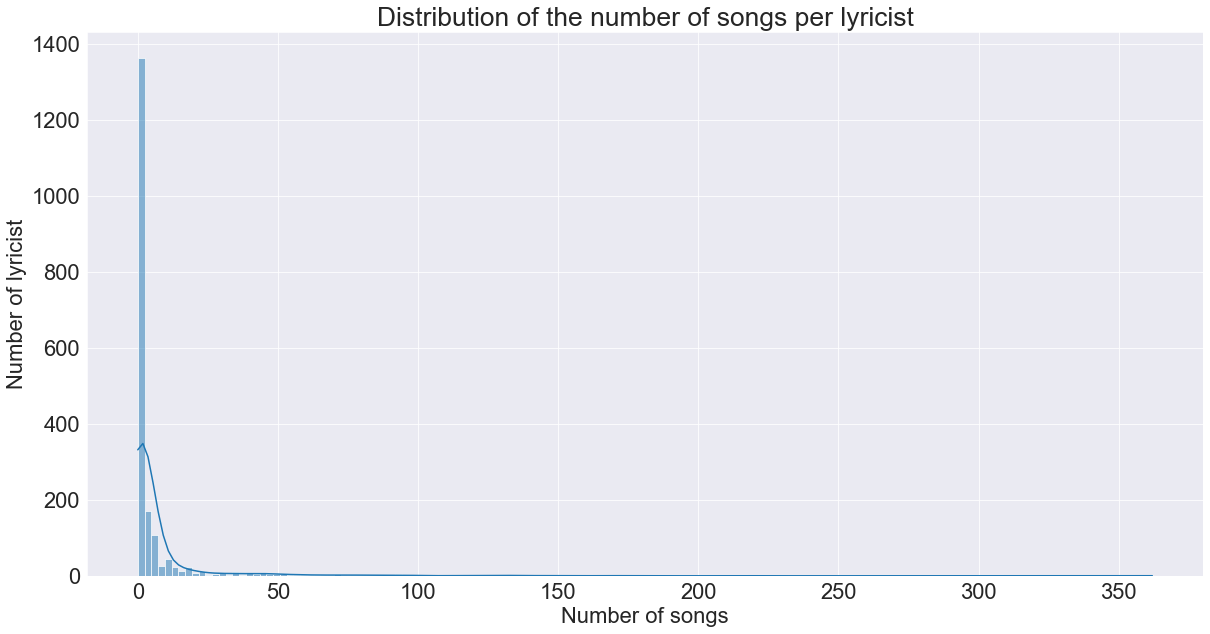

In [81]:
# Plot the distribution of the number of songs per artist
# Get the number of songs per lyricist
songs_per_lyricist = df.groupby('lyricist').count()['lyrics']
# Plot the distribution
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 22})
plt.title('Distribution of the number of songs per lyricist')
plt.xlabel('Number of songs')
plt.ylabel('Number of lyricist')
sns.histplot(songs_per_lyricist, bins=150, kde=True);

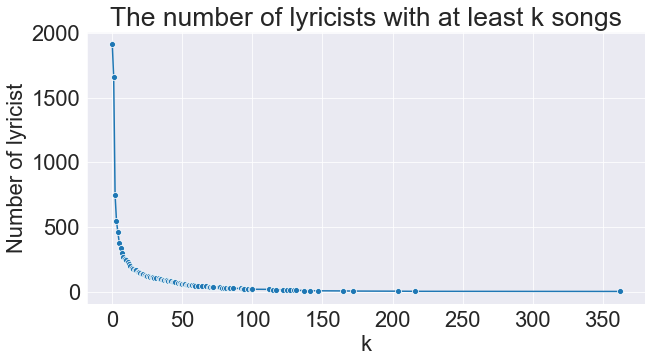

In [82]:
# Plot the number of artists with at least k songs
artists_per_songs = songs_per_lyricist.value_counts().sort_index(ascending=False)
artists_per_threshold = artists_per_songs.cumsum()
plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 22})
plt.title('The number of lyricists with at least k songs')
plt.xlabel('k')
plt.ylabel('Number of lyricist')
sns.lineplot(data=artists_per_threshold, marker='o');

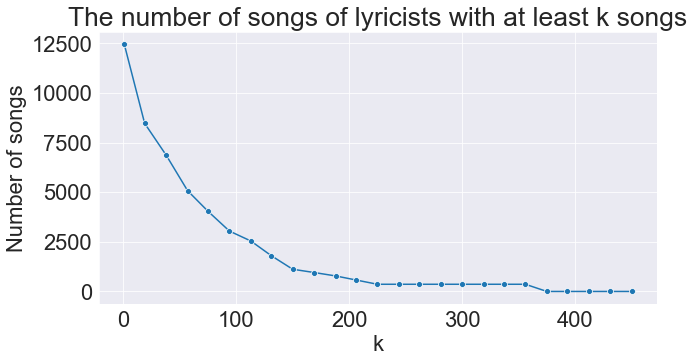

In [84]:
threshold = np.linspace(1, 450, 25, dtype=int)
songs_per_threshold = [(songs_per_lyricist[songs_per_lyricist >= threshold]).sum() for threshold in threshold]
plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 22})
plt.title('The number of songs of lyricists with at least k songs')
plt.xlabel('k')
plt.ylabel('Number of songs')
sns.lineplot(x=threshold, y=songs_per_threshold, marker='o');

We can see that choosing a value of $k=50$ will result in having 5555 songs and 56 artists, a reasonable dataset and therefore the chosen one.
All lyricists with less than this number of songs will have to go.
Once again, we will keep these lyricists for the experimental part of the project, for example for Zero-Shot-Learning.

In [104]:
k = 50
counts = df['lyricist'].value_counts()
lyricists_to_keep = counts[counts >= k].index
lyricists_to_remove = counts[counts < k].index
experimental = df[df['lyricist'].isin(lyricists_to_remove)]
experimental.to_csv('./experimental.csv', index=False, encoding = 'utf-8-sig')
unique_df = df[df['lyricist'].isin(lyricists_to_keep)]

artists = unique_df['lyricist'].unique()
print(f"Total number of lyricists in experimental: {len(experimental['lyricist'].unique())}")
print(f"Total number of lyricists in the updated dataset: {len(unique_df['lyricist'].unique())}")
print(f"The shape of the updated dataset: {unique_df.shape}")

Total number of lyricists in experimental: 1600
Total number of lyricists in the updated dataset: 58
The shape of the updated dataset: (5555, 9)


## Hall of Fame
These are the lyricists with most songs:

In [107]:
unique_df['lyricist'].value_counts()

אהוד מנור         362
זאב נחמה          216
שלמה ארצי         204
שלום חנוך         172
אביב גפן          165
                 ... 
ערן חי פרץ          0
צ'ולו               0
צבי בורודובסקי      0
צבי מאנה מרדכי      0
אבנר צברי           0
Name: lyricist, Length: 1911, dtype: int64

## Splitting the data
One important thing to consider when splitting the data is to keep the ratio of songs by a lyricist in relation to the total number of songs for each instance of the lyricist - both in the training set and in the test set.
This is done by using the `stratify` option

In [111]:
from sklearn.model_selection import train_test_split

lyrics = unique_df['lyrics']
lyricists = unique_df['lyricist']
all_but_lyricists = unique_df[['index','lyrics','song_name','url','words count','unique words count','artist']]

X_train, X_test, y_train, y_test = train_test_split(all_but_lyricists, lyricists, test_size=0.1, stratify=lyricists)

# Save to CSV
train_df = pd.DataFrame(np.c_[ X_train,y_train], columns = ['index','lyrics','song_name','url','words count','unique words count','artist','lyricist'])
test_df = pd.DataFrame(np.c_[ X_test,y_test], columns = ['index','lyrics','song_name','url','words count','unique words count','artist','lyricist'])

print(f'train shape: {train_df.shape}, test shape: {test_df.shape}')
train_df.to_csv('./train.csv', index=False,encoding = 'utf-8-sig')
test_df.to_csv('./test.csv', index=False,encoding = 'utf-8-sig')

train shape: (4999, 8), test shape: (556, 8)
